In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score

In [ ]:
# ------------------------------------------------
# 1. RUTAS Y PARÁMETROS
# ------------------------------------------------
base_dir = "G:/Mi unidad/TESIS/MURA_2"
train_dir = os.path.join(base_dir, "train")
valid_dir = os.path.join(base_dir, "valid")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32  # Aumentamos el batch size para mejorar estabilidad

# Hiperparámetros mejorados
EPOCHS_FROZEN = 40
LEARNING_RATE_FROZEN = 1e-4

EPOCHS_UNFROZEN = 40  # Aumentamos las épocas de fine-tuning
LEARNING_RATE_UNFROZEN = 1e-6

NUM_LAYERS_UNFROZEN = 150  # Descongelamos más capas para ajuste fino

# ------------------------------------------------
# 2. DATA AUGMENTATION MEJORADO
# ------------------------------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.4,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)

# ------------------------------------------------
# 3. CÁLCULO DE PESOS DE CLASE
# ------------------------------------------------
y_train = train_generator.classes

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("\n🔹 Pesos de clase calculados:", class_weight_dict)

# ------------------------------------------------
# 4. CARGAR MODELO PREENTRENADO (ResNet50)
# ------------------------------------------------
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelar capas base inicialmente

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('swish')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

Found 32004 images belonging to 2 classes.
Found 8001 images belonging to 2 classes.

🔹 Pesos de clase calculados: {0: 1.2194787379972565, 1: 0.8474737845567207}


In [ ]:
# ------------------------------------------------
# 5. ENTRENAMIENTO FASE 1 (CAPAS CONGELADAS)
# ------------------------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_FROZEN),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7, verbose=1)

print("\n=== Entrenamiento Fase 1 (capas base congeladas) ===")
history_frozen = model.fit(
    train_generator, validation_data=valid_generator,
    epochs=EPOCHS_FROZEN, callbacks=[early_stopping, reduce_on_plateau], class_weight=class_weight_dict
)

# ------------------------------------------------
# 6. ENTRENAMIENTO FASE 2 (FINE-TUNING)
# ------------------------------------------------
for layer in base_model.layers[-NUM_LAYERS_UNFROZEN:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_UNFROZEN),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n=== Entrenamiento Fase 2 (fine-tuning) ===")
history_unfrozen = model.fit(
    train_generator, validation_data=valid_generator,
    epochs=EPOCHS_UNFROZEN, callbacks=[early_stopping, reduce_on_plateau], class_weight=class_weight_dict
)


=== Entrenamiento Fase 1 (capas base congeladas) ===
Epoch 1/40
1001/1001 [==============================] - 533s 525ms/step - loss: 0.7700 - accuracy: 0.5233 - val_loss: 0.6636 - val_accuracy: 0.6082 - lr: 1.0000e-04
Epoch 2/40
1001/1001 [==============================] - 500s 499ms/step - loss: 0.7281 - accuracy: 0.5413 - val_loss: 0.6532 - val_accuracy: 0.6062 - lr: 1.0000e-04
Epoch 3/40
1001/1001 [==============================] - 500s 500ms/step - loss: 0.7144 - accuracy: 0.5472 - val_loss: 0.6945 - val_accuracy: 0.5457 - lr: 1.0000e-04
Epoch 4/40
1001/1001 [==============================] - 503s 503ms/step - loss: 0.7013 - accuracy: 0.5548 - val_loss: 0.6806 - val_accuracy: 0.5607 - lr: 1.0000e-04
Epoch 5/40
1001/1001 [==============================] - 504s 503ms/step - loss: 0.6977 - accuracy: 0.5561 - val_loss: 0.7576 - val_accuracy: 0.4789 - lr: 1.0000e-04
Epoch 6/40
1001/1001 [==============================] - 505s 504ms/step - loss: 0.6895 - accuracy: 0.5621 - val_loss: 0.7

251/251 [==============================] - 54s 213ms/step
=== Evaluación en validación ===
Accuracy: 0.7298
Precision: 0.8236
Recall (Sensibilidad): 0.6896
F1-Score: 0.7507

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

 No Fractura       0.64      0.79      0.71      3281
    Fractura       0.82      0.69      0.75      4720

    accuracy                           0.73      8001
   macro avg       0.73      0.74      0.73      8001
weighted avg       0.75      0.73      0.73      8001



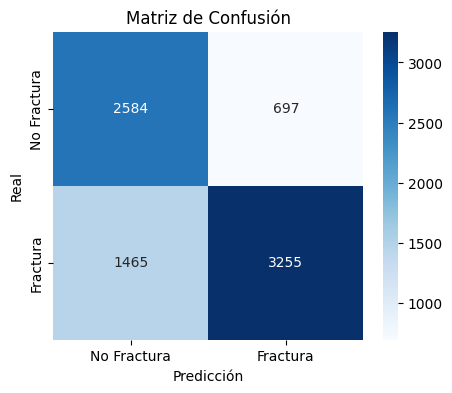

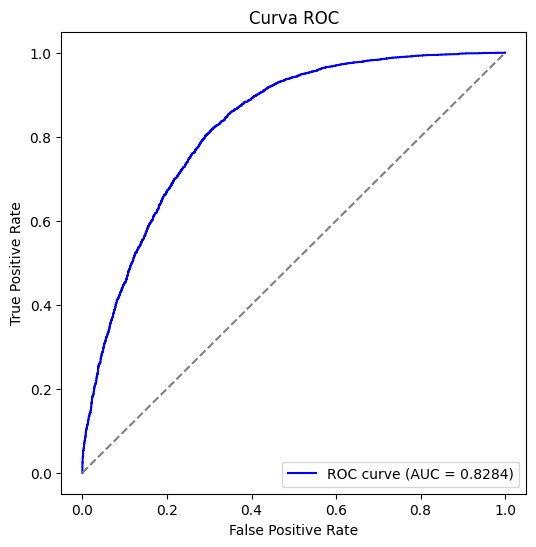

In [ ]:
# ------------------------------------------------
# Evaluación en Validación y Reporte de Clasificación
# ------------------------------------------------
y_true = valid_generator.classes
y_pred_probs = model.predict(valid_generator)

threshold = 0.6
y_pred = (y_pred_probs > threshold).astype("int32")

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

report = classification_report(y_true, y_pred, target_names=["No Fractura", "Fractura"])

print(f"=== Evaluación en validación ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensibilidad): {recall:.4f}")
print(f"F1-Score: {f1:.4f}\n")
print("=== Reporte de Clasificación ===")
print(report)

# ------------------------------------------------
# Matriz de Confusión
# ------------------------------------------------
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=["No Fractura", "Fractura"],
            yticklabels=["No Fractura", "Fractura"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# ------------------------------------------------
# Curva ROC
# ------------------------------------------------
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

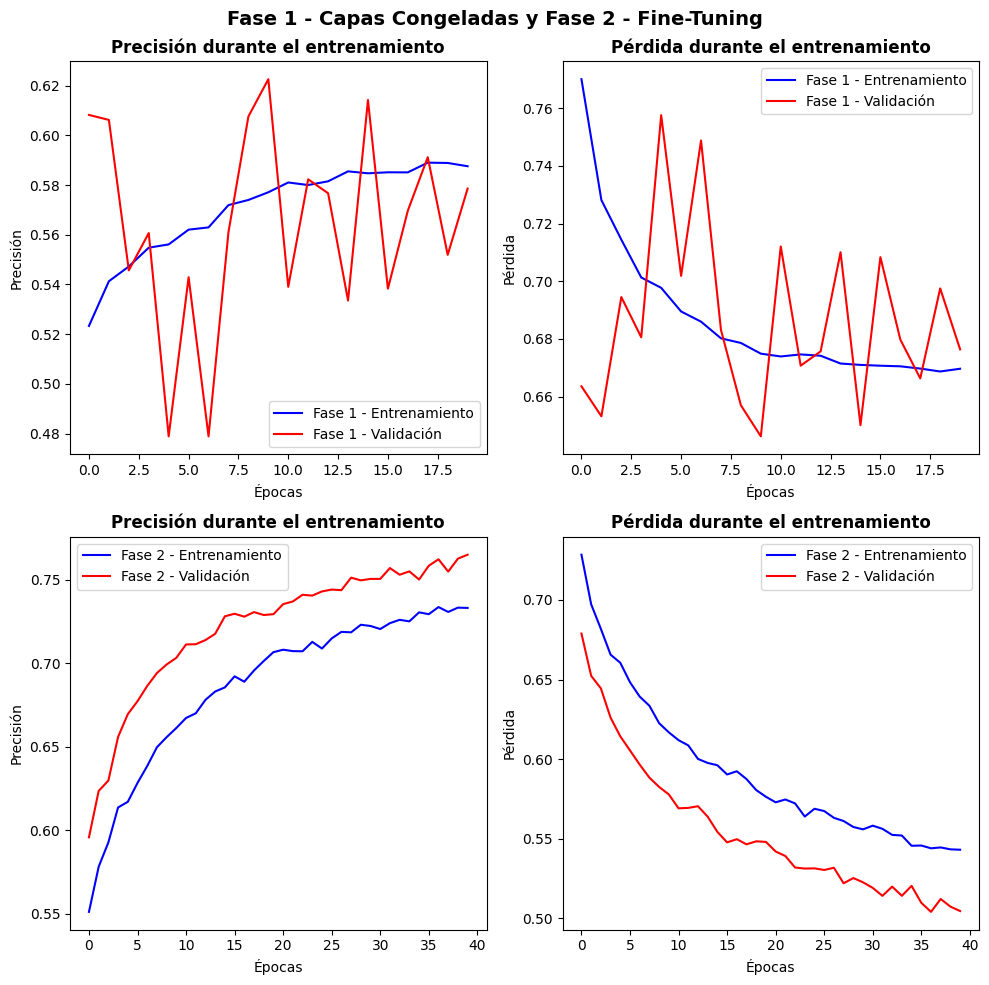

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc

# ------------------------------------------------
# Gráfico de Entrenamiento
# ------------------------------------------------
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("Fase 1 - Capas Congeladas y Fase 2 - Fine-Tuning", fontsize=14, fontweight='bold')

axs[0, 0].plot(history_frozen.history['accuracy'], label='Fase 1 - Entrenamiento', color='blue')
axs[0, 0].plot(history_frozen.history['val_accuracy'], label='Fase 1 - Validación', color='red')
axs[0, 0].set_title("Precisión durante el entrenamiento", fontsize=12, fontweight='bold')
axs[0, 0].set_xlabel("Épocas")
axs[0, 0].set_ylabel("Precisión")
axs[0, 0].legend()

axs[0, 1].plot(history_frozen.history['loss'], label='Fase 1 - Entrenamiento', color='blue')
axs[0, 1].plot(history_frozen.history['val_loss'], label='Fase 1 - Validación', color='red')
axs[0, 1].set_title("Pérdida durante el entrenamiento", fontsize=12, fontweight='bold')
axs[0, 1].set_xlabel("Épocas")
axs[0, 1].set_ylabel("Pérdida")
axs[0, 1].legend()

axs[1, 0].plot(history_unfrozen.history['accuracy'], label='Fase 2 - Entrenamiento', color='blue')
axs[1, 0].plot(history_unfrozen.history['val_accuracy'], label='Fase 2 - Validación', color='red')
axs[1, 0].set_title("Precisión durante el entrenamiento", fontsize=12, fontweight='bold')
axs[1, 0].set_xlabel("Épocas")
axs[1, 0].set_ylabel("Precisión")
axs[1, 0].legend()

axs[1, 1].plot(history_unfrozen.history['loss'], label='Fase 2 - Entrenamiento', color='blue')
axs[1, 1].plot(history_unfrozen.history['val_loss'], label='Fase 2 - Validación', color='red')
axs[1, 1].set_title("Pérdida durante el entrenamiento", fontsize=12, fontweight='bold')
axs[1, 1].set_xlabel("Épocas")
axs[1, 1].set_ylabel("Pérdida")
axs[1, 1].legend()

plt.tight_layout()
plt.show()